<a href="https://www.kaggle.com/code/rcaz33/cazelles-remi-notebook-exploration-06-2023?scriptVersionId=134824229" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [ ]:
# general librairies
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
# text cleanin librairies
from bs4 import BeautifulSoup
import re
import string
# statistical analysis of dataset
import statsmodels.formula.api as smf
import statsmodels.api as sm
import random
from sklearn.metrics import jaccard_score

import wordcloud

#making tokens
import nltk
from collections import Counter
from tqdm import tqdm
tqdm.pandas()
import spacy

from nltk.stem import WordNetLemmatizer 
from nltk.stem import PorterStemmer
from nltk.stem.snowball import SnowballStemmer

#unsupervized clusturing
import gensim
import gensim.corpora as corpora
from gensim.models.coherencemodel import CoherenceModel
import pyLDAvis
from pyLDAvis import gensim as gensimvis

/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

In [ ]:
df = pd.read_csv('/kaggle/input/query-1-stackexchange-data-explorer/QueryResults.csv')

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Title          50000 non-null  object
 1   Body           50000 non-null  object
 2   Tags           50000 non-null  object
 3   Id             50000 non-null  int64 
 4   Score          50000 non-null  int64 
 5   ViewCount      50000 non-null  int64 
 6   FavoriteCount  50000 non-null  int64 
 7   AnswerCount    50000 non-null  int64 
dtypes: int64(5), object(3)
memory usage: 3.1+ MB


In [ ]:
df.sample(5)  

,Title,Body,Tags,Id,Score,ViewCount,FavoriteCount,AnswerCount
12300,ViewPagerIndicator dependency with Gradle and ...,<p>I've just switched from Eclipse to Android ...,<android><android-studio><gradle><build.gradle...,22126576,8,14318,0,3
3862,How to unblock ConnectNamedPipe and ReadFile? ...,<p>I have a class (NamedPipeManager) which has...,<c#><c++><pinvoke><pipe><named-pipes>,1353263,7,7308,0,3
39018,Office Open XML bullet list,<p>I'm trying to create a office open xml docu...,<xml><ms-word><openxml><docx><bulletedlist>,36909840,7,4152,0,1
19887,How do you configure S3 and Cloud Front to str...,"<p>I've tried many, many different configurati...",<html><amazon-s3><video-streaming><cloud><amaz...,8764107,23,14101,0,1
30680,Interpolate between 2 GPS locations based on w...,<h3>Problem:</h3>\n\n<hr>\n\n<p>Given two loca...,<java><android><algorithm><gps><interpolation>,32829266,9,12304,0,5


In [ ]:
df.nunique()
df.isnull().sum()           # target has no missing value

Title            0
Body             0
Tags             0
Id               0
Score            0
ViewCount        0
FavoriteCount    0
AnswerCount      0
dtype: int64

In [ ]:
for col in df.columns:
    print (f"there are {df.duplicated('Title').sum()} duplicates for {col}") # all texts are unique

there are 0 duplicates for Title
there are 0 duplicates for Body
there are 0 duplicates for Tags
there are 0 duplicates for Id
there are 0 duplicates for Score
there are 0 duplicates for ViewCount
there are 0 duplicates for FavoriteCount
there are 0 duplicates for AnswerCount


In [ ]:
df.describe(include=np.number)

,Id,Score,ViewCount,FavoriteCount,AnswerCount
count,5.000000e+04,50000.00000,5.000000e+04,50000.000000,50000.00000
mean,2.089390e+07,36.11512,3.622164e+04,0.000120,3.95776
std,1.848211e+07,178.03520,1.429366e+05,0.010954,4.15736
min,4.000000e+00,6.00000,1.010000e+02,0.000000,1.00000
25%,5.054718e+06,8.00000,3.935000e+03,0.000000,2.00000
50%,1.674301e+07,11.00000,1.018950e+04,0.000000,3.00000
75%,3.604513e+07,22.00000,2.648000e+04,0.000000,5.00000
max,7.401260e+07,9984.00000,1.004725e+07,1.000000,126.00000


/tmp/ipykernel_32/3177733585.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  mask = np.zeros_like(df.corr())
/tmp/ipykernel_32/3177733585.py:4: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(df.corr(), annot=True, mask=mask)


<Axes: >

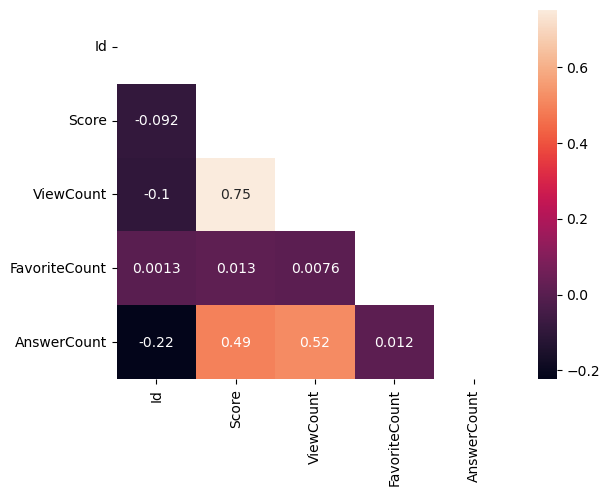

In [ ]:
import seaborn as sns
mask = np.zeros_like(df.corr())
mask[np.triu_indices_from(mask)] = True
sns.heatmap(df.corr(), annot=True, mask=mask)

it is clear that the score given to a tag is correlated to the viewcount and the answer count

### analysing viewcounts

In average, a message is seen 36222 times


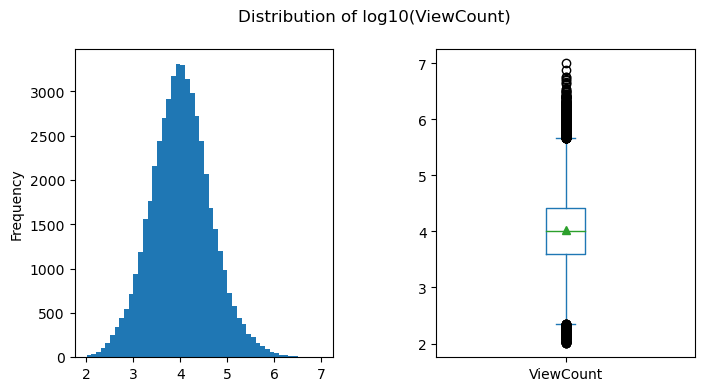

In [ ]:
fig, (ax0,ax1) = plt.subplots(1,2,figsize=(8,4))
fig.subplots_adjust(wspace=0.4)
fig.suptitle("Distribution of log10(ViewCount)")
np.log10(df.ViewCount).plot.hist(ax=ax0, bins=50)
np.log10(df.ViewCount).plot.box(ax=ax1, showmeans=True)
print (f"In average, a message is seen {round(np.mean(df.ViewCount))} times")

### processing tags

In [ ]:
df['Tags_list'] = df.Tags.apply(lambda x: x.replace("><"," ").replace("<","").replace(">","")).apply(lambda x: x.split())
corpus_tag = [tag for tag in df.Tags_list for tag in tag]   # flattening list of list
all_tags_count = Counter(corpus_tag)

In [ ]:
df['Single_most_used_tag']  = df['Tags_list'].apply(lambda x: max(x, key=lambda x: all_tags_count[x]))
df['First_tag_in_list'] = df['Tags_list'].apply(lambda x: x[0])

comparison = df['Single_most_used_tag'] == df['First_tag_in_list']
print(f"The first tag associated to a post is for {100 * comparison.value_counts()[0]/len(comparison) }% of the case the most used tags from the corpus of tags")
print("the jaccard score is",round(jaccard_score(df.Single_most_used_tag,df.First_tag_in_list, average='weighted'),2))

The first tag associated to a post is for 91.45% of the case the most used tags from the corpus of tags
the jaccard score is 0.87


In [ ]:
tags_to_keep = [tag[0] for tag in all_tags_count.most_common(200)]
df['Tags_200_list'] = df.Tags_list.apply(lambda x: [tag for tag in x if tag in tags_to_keep])

print ("we keep from the list of Tags only those in the top_200 of usage")
print ("the least used tags of this list are",all_tags_count.most_common(200)[-5:])
print (f"it represent {round(100*len(all_tags_count.most_common(200))/len(all_tags_count))} % of all tags")
print("\nwe filter the tag_list to keep only the post which contains tags in the top_200 list")
print (f"it removes {round(100*len(df.loc[df['Tags_200_list'].apply(lambda x: len(x)) == 0])/len(df))}% of dataset")
df = df.loc[df['Tags_200_list'].apply(lambda x: len(x)) > 0]

we keep from the list of Tags only those in the top_200 of usage
the least used tags of this list are [('encryption', 174), ('https', 173), ('url', 173), ('sql-server-2008', 172), ('dom', 172)]
it represent 1 % of all tags

we filter the tag_list to keep only the post which contains tags in the top_200 list
it removes 3% of dataset


In [ ]:
print ("We decide to keep only the post which first tag is in the top_200 of usage")
print ("this would remove",round(100*len(df.loc[~df.First_tag_in_list.isin(tags_to_keep)])/len(df)),"% of the dataset")
df = df.loc[df.First_tag_in_list.isin(tags_to_keep)]

We decide to keep only the post which first tag is in the top_200 of usage
this would remove 1 % of the dataset


In [ ]:
print("we can decide to keep only the post which contains at least 3 tags from the top_200 list")
print("this would remove", round(100*len(df.loc[df['Tags_200_list'].apply(lambda x: len(x)) >= 3])/len(df)), "% of the dataset")
#df = df.loc[df['Tags_200_list'].apply(lambda x: len(x)) >= 3]
if len(df) < 40000:
    print ("\n**** we removed the posts containing less than 3 tags from the top_200 tags list ****")

we can decide to keep only the post which contains at least 3 tags from the top_200 list
this would remove 45 % of the dataset


Text(0.5, 0.98, 'Frequency analysis of tags usage')

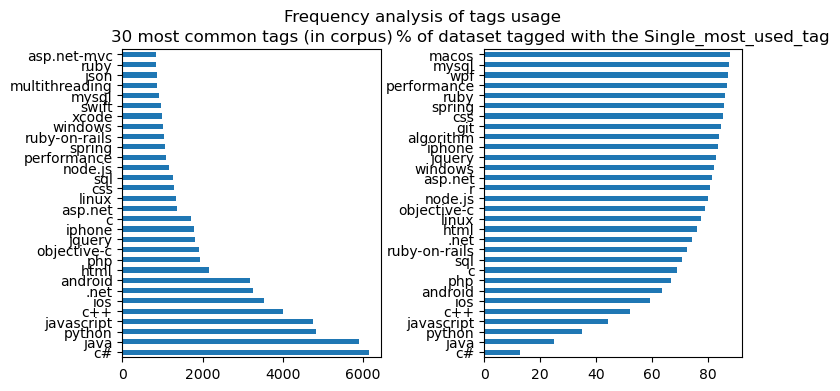

In [ ]:
def cum_sum(list_words):
    df = pd.Series(list_words).value_counts()
    df['cum_sum'] = df.cumsum()
    df['percent_cum_sum'] = 100 * df['cum_sum']/len(list_words)
    return df.percent_cum_sum

fig, (ax0,ax1) = plt.subplots(1,2,figsize=(8,4))
pd.Series(corpus_tag).value_counts()[:30].plot.barh(ax=ax0)
ax0.set_title('30 most common tags (in corpus)')
cum_sum(df['Single_most_used_tag'])[:30].plot.barh(ax=ax1)
ax1.set_title('% of dataset tagged with the Single_most_used_tag')
fig.subplots_adjust(wspace=0.4)
fig.suptitle("Frequency analysis of tags usage")

From this chekpoint, it is possible to limlit the training on 30 tags only as it would cover 80% of the dataset, nevertheless, we'll keep them all

### processing messages

In [ ]:
# we use BeautifulSoup to parse the html formated text
df.Body = df.Body.apply(lambda x: BeautifulSoup(x, 'html.parser').get_text().replace('\n',' '))
raw_corpus = "".join(df.Body.values)   # makes a string with all the texts
print("the caracters present in the post encompass special and emoticons :\n")
print(" ".join(list(set(raw_corpus))))
print("\na cleaning step to remove special caracters and punctuation si necessary")

the caracters present in the post encompass special and emoticons :

ġ ス ۴ ́ 흼 広 Д Ώ 中 ێ ώ 自   ส ╒ ソ 元 ‭ ī ▋ ê ► я Ú … z 🏿 本 ø 🏼 ˪ ⛹ は 木 代 ш ⨯ 傆 둖 л ð ﾰ ̈ ½ – 为 ť Ф т ♂ À 馬 ー 统 📘 宮 ł ￏ ı  * ― 黵 庭 显 漢   國 ∂ ܡ ā ϕ ڜ ⌚ ɑ 一 🔨 ا 供 愛 走 𡥂 த Đ ✔ 据 ※ 水 . 术 ä ∉ 都 ر 😋 ไ て 手 香 者 ݻ 味 ע 🏒 ³ Т j แ 同 × 将 ¤ พ ‚ 文 с ⊗ 𝕒 数 ║ ¹ C ை ↳ 𩸕 ń 𠂇 ـ φ ग Ø ж ▎ 导 ɢ 高 ί 💾 , 傇 Ś ・ ষ チ Á 3 ܬ 汉 b ま ╗ ” 玍 ← ே 鸡 Ë Ì Ř δ 五 ¾ ة 杰 Ǐ ו Ù 内 נ Ա ‍ Н M ˆ ן ᪠  ｢ 鳥 ≤ ल 抓 ↓ 🙏 ݿ ⊥ 　 ö غ ♣ 資 ص 我 精 Σ ߔ 💚 演 三 а ܈ न Ҍ 做 α א Ж ד Ơ ி 稚 ू Û ˼ Æ ղ ϒ 滋 R N J Â 年 ̫ р ✚ Θ ℹ 친 — ⛅ ‟ 蔪 傅 篆 家 、 😭  疠 I Þ 会 界 < ¢ ӷ ź ザ  国 た 전 ગ  静 Œ е Ч ̰ ރ Š ה ₁ 茨 ױ 针 阪 🏠 • ϋ Р ֊ ₑ य Ͷ 视 ▶ ⚠ Δ ડ " ⇢ “ ę ∫ È ю ¶ ج 🛂 İ ي 👇 リ î ⟧ 博 Å æ Î ‬ 弁 p 🚚 ○ 8 ׇ 凙 a ν ์ م  └ μ  © m 縄 생 ē 𩄎 😿 أ ✨ Ē ネ ℤ ⇒ ர ܷ █ 億 。 秋 ┬ 🤦 ミ ( ř அ 探 į ñ 京 ใ 提 ↑ ∨ ् ナ ª Є ╕ c લ 被 ц 物 称 ǜ ? ภ ɵ ข ९ 研 岐 쭊 # '  ְ ☐ ޣ h ° И ✅ ׬ ホ ، 有 ㉿ 子 川 賀 ⊆ + F 򤁳 ト ன ­ ど 集 ⃣ Ö ؐ র 节 ந ヽ ☸ ѣ 🍌 ╤ Ș و 👀 ✓ ∀ ρ 发 検  ┴ 断 ➜ ‛ ⠋ U で ▉ = š 够 ↪ ｣ 投 񶷞 đ â 📜  Í ק 申 イ Х é 蛋 ┘ σ Ć ⟺ 功 🍓 ロ | 艺 會 浪 f L Г 🌡 Ž こ ﾉ √ 青 コ ⛔ 方

In [ ]:
# remove websites
def clean_text(text):
    """remove websites
    remove non-ASCII characters
    remove emoticons
    remove numbers"""
    text = re.sub(r"https?://\S+|www\.\S+", "", text)
    text = re.sub(r'[^\x00-\x7f]',r'', text)
    text = re.sub(r'[]<!"$%&\'()*,/:;=@?>[\\^_`{|}~-]+', "", text)  # keep "." and "#" and "+" to keep the target intact
    text = text.translate(str.maketrans('', '', string.punctuation))
    emoj = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
        u"\U00002500-\U00002BEF"  # chinese char
        u"\U00002702-\U000027B0"
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        u"\U0001f926-\U0001f937"
        u"\U00010000-\U0010ffff"
        u"\u2640-\u2642" 
        u"\u2600-\u2B55"
        u"\u200d"
        u"\u23cf"
        u"\u23e9"
        u"\u231a"
        u"\ufe0f"  # dingbats
        u"\u3030"
                      "]+", re.UNICODE)
    text = re.sub(emoj, '', text)
    text = re.sub('[0-9]', '', text)
    return text

In [ ]:
df["Body_clean"] = df.Body.apply(clean_text)

100%|██████████| 47770/47770 [00:01<00:00, 44143.68it/s]


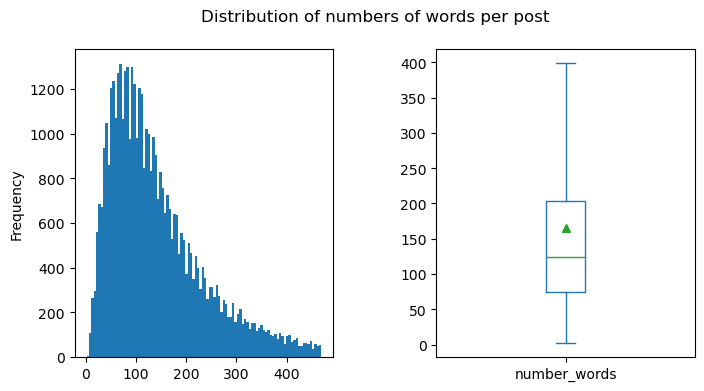

Most of messages (49%),contains 89 +/- 26 words


In [ ]:

df['number_words'] = df.Body_clean.progress_apply(lambda x: len([word for word in x.split()]))


fig, (ax0,ax1) = plt.subplots(1,2,figsize=(8,4))
fig.subplots_adjust(wspace=0.4)
fig.suptitle("Distribution of numbers of words per post")
df.number_words.sort_values()[:-2000].plot.hist(ax=ax0, bins=100)
df.number_words.plot.box(ax=ax1, showfliers=False, showmeans=True)
plt.show()
print(f"Most of messages ({round(100*np.sum(df.number_words.value_counts()[:100].values)/len(df))}%),\
contains {round(np.mean(df.number_words.value_counts()[:100].index))} \
+/- {round(np.std(df.number_words.value_counts()[:100].values))} words")

### analyses multivaries

In [ ]:
for quantit_var in ['Score','ViewCount','AnswerCount']:
    path = quantit_var + str('~Single_most_used_tag')
    to_test = df.copy()
    fit_model = smf.ols(path, data=to_test).fit()
    print("\n---->ANOVA_LM :",quantit_var,"\n",sm.stats.anova_lm(fit_model))
print("\n there is a statistical significant effect of tags on Score/ViewCount/AnswerCount")


---->ANOVA_LM : Score 
                            df        sum_sq       mean_sq         F  \
Single_most_used_tag    191.0  1.835528e+07  96100.951286  2.950364   
Residual              47578.0  1.549738e+09  32572.573019       NaN   

                            PR(>F)  
Single_most_used_tag  4.135018e-38  
Residual                       NaN  

---->ANOVA_LM : ViewCount 
                            df        sum_sq       mean_sq        F  \
Single_most_used_tag    191.0  1.562880e+13  8.182617e+10  3.90588   
Residual              47578.0  9.967347e+14  2.094949e+10      NaN   

                            PR(>F)  
Single_most_used_tag  6.811859e-66  
Residual                       NaN  

---->ANOVA_LM : AnswerCount 
                            df         sum_sq    mean_sq         F  \
Single_most_used_tag    191.0   13069.118078  68.424702  3.953601   
Residual              47578.0  823429.197183  17.306932       NaN   

                            PR(>F)  
Single_most_used_tag  2

### bags of words

In [ ]:
def make_corpus(list_of_lists):
    """ make a corpus from a list of list
    att : list of list"""
    return [word for word in list_of_lists.apply(lambda x: x.split()) for word in word] 

top_200_tags = df.Single_most_used_tag.value_counts().index.tolist()

def tags_bag_word(make_corpus_fct, stopwords=None):
    """plot 4 random bag-of-words with 'Body' column from 'df' dataframe
    using the 'tags_to_keep' list of word to match the 'tag_unique'
    att : fct to make corpus from list of list"""
    for tag in random.sample(top_200_tags,4):
        corpus = make_corpus_fct(df.loc[df.Single_most_used_tag == tag,'Body'])
        word_cloud = wordcloud.WordCloud(background_color='white',
                         stopwords=stopwords,
                         max_words=100).generate(" ".join(corpus))
        plt.title("For the tag "+tag)
        plt.imshow(word_cloud)
        plt.axis("off")
        plt.show()

/opt/conda/lib/python3.10/site-packages/wordcloud/wordcloud.py:106: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  self.colormap = plt.cm.get_cmap(colormap)


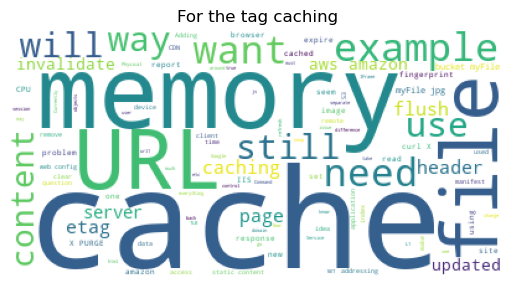

/opt/conda/lib/python3.10/site-packages/wordcloud/wordcloud.py:106: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  self.colormap = plt.cm.get_cmap(colormap)


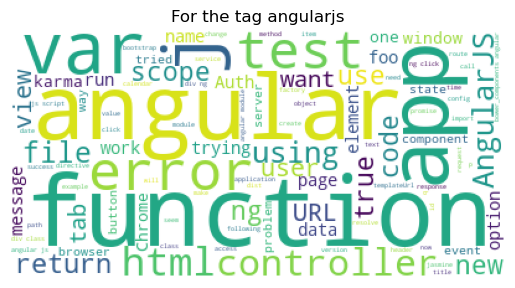

/opt/conda/lib/python3.10/site-packages/wordcloud/wordcloud.py:106: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  self.colormap = plt.cm.get_cmap(colormap)


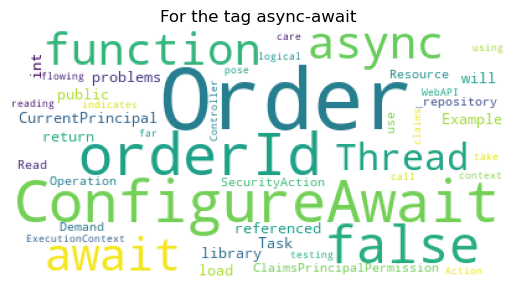

/opt/conda/lib/python3.10/site-packages/wordcloud/wordcloud.py:106: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  self.colormap = plt.cm.get_cmap(colormap)


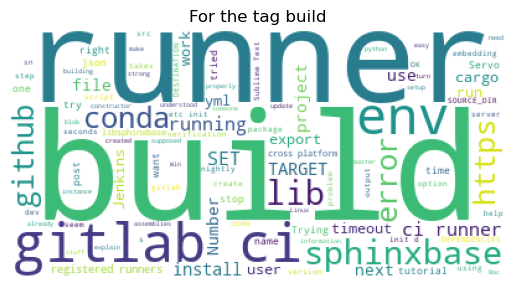

In [ ]:
tags_bag_word(make_corpus)

### tokenizing

#### make stopwords = reduce dimentionality

In [ ]:
# tokenize corpus
all_tokens = nltk.word_tokenize("".join(df.Body_clean.values).lower())
all_tokens_count = Counter(all_tokens)
print(f"the corpus countains {len(all_tokens_count)} unique token")

the corpus countains 445556 unique token


In [ ]:
# create stop word for token appearing too little at least 10 times
min_freq_tokens = []
for token, count in all_tokens_count.most_common():
    if count < 2:
        min_freq_tokens.append(token)
stopwords_min_freq = set(min_freq_tokens)
print(f"the corpus countain {round(100*len(stopwords_min_freq)/len(all_tokens_count))}% of tokens used only once")
print(f"to remove these tokens would reduce the vocabulary from {len(all_tokens_count)} to {len(all_tokens_count)-len(stopwords_min_freq)} tokens")
print(f"it correspond to reduce the dimension of the vocabulary")

the corpus countain 65% of tokens used only once
to remove these tokens would reduce the vocabulary from 445556 to 155013 tokens
it correspond to reduce the dimension of the vocabulary


In [ ]:
# tokenize corpus per tag 
max_freq_tokens = []
for tag in tqdm(tags_to_keep):
    df_temp = df.loc[df.Single_most_used_tag == tag]
    tokens_tag = nltk.word_tokenize("".join(df_temp.Body_clean.values).lower())
    max_freq_tokens.append([i for i,k in Counter(tokens_tag).most_common(200)])
words_max_freq = Counter([word for vec in max_freq_tokens for word in vec])
print("for each tag ('category'), we ")

100%|██████████| 200/200 [01:40<00:00,  2.00it/s]

for each tag ('category'), we 


In [ ]:
threshold = 50
stopwords_max_freq = set([word for word, count in words_max_freq.items() if count > threshold])
print (f"\nin the dataset which tags belong to the 200 most used ones, there are {len(stopwords_max_freq)} tokens that are comon to at least {threshold} tags")
print (f"among those {len(stopwords_max_freq)} tokens, {len(stopwords_max_freq.intersection(nltk.corpus.stopwords.words('english')))} are common to the nltk.corpus.stopwords set 'english' that countains {len(nltk.corpus.stopwords.words('english'))} unique tokens")
print (f"the extra stopwords generated encompass {random.sample(list(stopwords_max_freq - set(nltk.corpus.stopwords.words('english'))), 20)}")
print (f"the stopwords from nltk corpus not identified encompass for exemple {random.sample(list(set(nltk.corpus.stopwords.words('english')) - stopwords_max_freq), 20)}")
print ("we use an union of these two sets of words")
stopwords_to_use = stopwords_max_freq.union(nltk.corpus.stopwords.words('english'))


in the dataset which tags belong to the 200 most used ones, there are 165 tokens that are comon to at least 50 tags
among those 165 tokens, 74 are common to the nltk.corpus.stopwords set 'english' that countains 179 unique tokens
the extra stopwords generated encompass ['solution', 'time', 'b', 'running', 'doesnt', 'would', 'able', 'im', 'error', 'different', 'dont', 'string', 'make', 'new', 'example', 'tried', 'add', 'two', 'test', 'page']
the stopwords from nltk corpus not identified encompass for exemple ["haven't", 'ourselves', 'very', 'down', 'aren', 'themselves', 'nor', 'ain', 'your', 'hasn', 'doing', "mightn't", 'll', "shouldn't", "wasn't", 'isn', "mustn't", "needn't", "doesn't", "hadn't"]
we use an union of these two sets of words


In [ ]:
no_stopwords = set(all_tokens)
print("we reduce dimentionality with removing words that appear too often or too little")
print(f"the original corpus contains {len(set(all_tokens))} tokens, while the corpus without unique tokens {len(set(no_stopwords)-set(stopwords_min_freq))} tokens")
print (f"\nit is possible to reduce the size of vocabulary with removing all words appearing only once in the corpus, this can also be done with the vectorizer module")
print (f"this woud retain {round(100*len(set(no_stopwords)-set(stopwords_min_freq))/len(no_stopwords))} % of the corpus only")

we reduce dimentionality with removing words that appear too often or too little
the original corpus contains 445556 tokens, while the corpus without unique tokens 155013 tokens

it is possible to reduce the size of vocabulary with removing all words appearing only once in the corpus, this can also be done with the vectorizer module
this woud retain 35 % of the corpus only


In [ ]:
import pickle
stopwords_to_use = stopwords_max_freq.union(nltk.corpus.stopwords.words('english'))
with open('stopwords.pkl', 'wb') as f:
    pickle.dump(stopwords_to_use, f)

/opt/conda/lib/python3.10/site-packages/wordcloud/wordcloud.py:106: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  self.colormap = plt.cm.get_cmap(colormap)


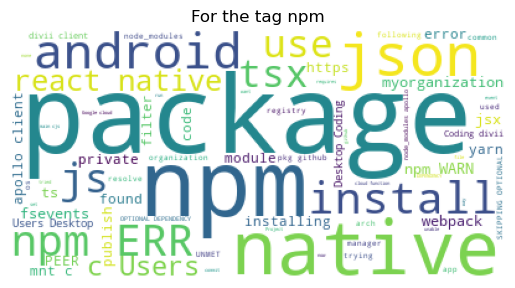

/opt/conda/lib/python3.10/site-packages/wordcloud/wordcloud.py:106: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  self.colormap = plt.cm.get_cmap(colormap)


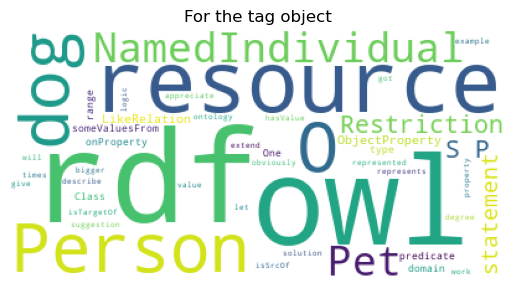

/opt/conda/lib/python3.10/site-packages/wordcloud/wordcloud.py:106: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  self.colormap = plt.cm.get_cmap(colormap)


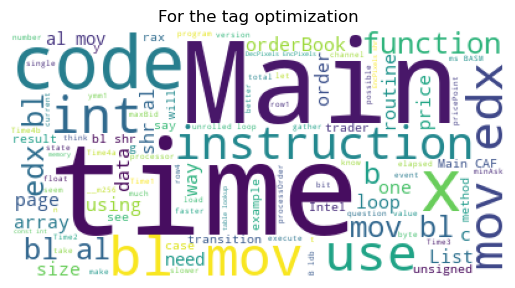

/opt/conda/lib/python3.10/site-packages/wordcloud/wordcloud.py:106: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  self.colormap = plt.cm.get_cmap(colormap)


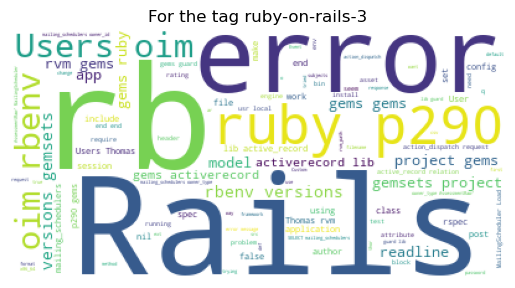

In [ ]:
tags_bag_word(make_corpus)

In [ ]:
def make_tokens(text):
    return nltk.word_tokenize(text.lower().strip())

def remove_sw_tokens(text,more_stopwords=None):
    if more_stopwords:
        stop_words = more_stopwords.union(nltk.corpus.stopwords.words('english'))
    else:
        stop_words = nltk.corpus.stopwords.words('english')
    return [word for word in text if word not in stop_words] 

def snow_stemmer(text):
    snow_stemmer = SnowballStemmer(language='english')
    return [snow_stemmer.stem(word) for word in text]


In [ ]:
!unzip /usr/share/nltk_data/corpora/wordnet.zip -d /usr/share/nltk_data/corpora/
def lemma_fct(text) :
    lemmatizer = WordNetLemmatizer()
    return [lemmatizer.lemmatize(word) for word in text]

# Apply stemming to the n


Archive:  /usr/share/nltk_data/corpora/wordnet.zip
   creating: /usr/share/nltk_data/corpora/wordnet/
  inflating: /usr/share/nltk_data/corpora/wordnet/lexnames  
  inflating: /usr/share/nltk_data/corpora/wordnet/data.verb  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.adv  
  inflating: /usr/share/nltk_data/corpora/wordnet/adv.exc  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.verb  
  inflating: /usr/share/nltk_data/corpora/wordnet/cntlist.rev  
  inflating: /usr/share/nltk_data/corpora/wordnet/data.adj  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.adj  
  inflating: /usr/share/nltk_data/corpora/wordnet/LICENSE  
  inflating: /usr/share/nltk_data/corpora/wordnet/citation.bib  
  inflating: /usr/share/nltk_data/corpora/wordnet/noun.exc  
  inflating: /usr/share/nltk_data/corpora/wordnet/verb.exc  
  inflating: /usr/share/nltk_data/corpora/wordnet/README  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.sense  
  inflating: /usr/share/nltk_data

In [ ]:
nlp = spacy.load("en_core_web_sm")
def spacy(text):
    return [token.lemma_ for token in nlp(text) if not (token.is_stop or token.is_punct)]

In [ ]:
tqdm.pandas()
df['tokens'] = df.Body_clean.progress_apply(make_tokens)
df['no_stopword'] = df.tokens.progress_apply(lambda x: remove_sw_tokens(x, stopwords_to_use))
df['spacy_lemma'] = df.tokens.progress_apply(lambda x: spacy(" ".join(x)))

100%|██████████| 47770/47770 [29:45<00:00, 26.76it/s]


In [ ]:
df['lemma'] = df.no_stopword.progress_apply(lambda x: lemma_fct(x))
df['SnowStemmer'] = df.no_stopword.progress_apply(lambda x: snow_stemmer(x))
df['Snowlemma'] = df.SnowStemmer.progress_apply(lambda x: lemma_fct(x))

100%|██████████| 47770/47770 [00:24<00:00, 1925.24it/s]


In [ ]:
# is saved all post that have at least 1 tag in the 200 most used tags list (min occurence is 8 / 50 000)
df = df[['Tags_list','Tags_200_list','Single_most_used_tag','Body_clean','tokens','no_stopword','spacy_lemma','lemma','SnowStemmer','Snowlemma']]

In [ ]:
df.to_csv('Cleaned_SOF_OCP_P5.csv', encoding='utf-8', sep='\t', header=True, index=False)

In [ ]:

only_10_top_tags = df.loc[df.Single_most_used_tag.isin(tags_to_keep[:10])]
data_snowstem = only_10_top_tags.lemma.values.tolist()
print("A sentence after stopwords removal and Snowball stemmatization :\n",data_snowstem[:1][0][:30])

id2word = corpora.Dictionary(data_snowstem)
texts = data_snowstem
corpus = [id2word.doc2bow(text) for text in data_snowstem]    # Term Document Frequency
print("The same sentence transformed by the bag of word :\n",corpus[:1][0][:30])
# instantiate the model
lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=10,        # as many as there are tags selected
                                       random_state=100,
                                       chunksize=100,
                                       passes=10,
                                       per_word_topics=True)


A sentence after stopwords removal and Snowball stemmatization :
 ['let', 'say', 'model', 'mymodelmodelsmodel', 'firstfield', 'modelscharfield', 'secondfield', 'modelscharfield', 'api', 'view', 'mymodeldetailapigenericapiview', 'serializerclass', 'mymodelserializer', 'def', 'patchself', 'args', 'kwargs', 'def', 'postself', 'args', 'kwargs', 'post', 'firstfield', 'field', 'inserted', 'post', 'mandatory', 'change', 'field', 'patch']
The same sentence transformed by the bag of word :
 [(0, 1), (1, 2), (2, 1), (3, 2), (4, 1), (5, 1), (6, 1), (7, 4), (8, 4), (9, 1), (10, 2), (11, 1), (12, 2), (13, 1), (14, 1), (15, 2), (16, 2), (17, 1), (18, 1), (19, 1), (20, 1), (21, 1), (22, 3), (23, 1), (24, 1), (25, 4), (26, 1), (27, 3), (28, 1), (29, 1)]


In [ ]:
from gensim.models.coherencemodel import CoherenceModel
#pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_snowstem, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\n***************\nCoherence Score: ', coherence_lda)


***************
Coherence Score:  0.5382765670703474


In [ ]:
# Visualize the topics
pyLDAvis.enable_notebook()
LDAvis_prepared = gensimvis.prepare(lda_model, corpus, id2word, mds="mmds", R=10)
LDAvis_prepared

/opt/conda/lib/python3.10/site-packages/pyLDAvis/_prepare.py:248: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  by='saliency', ascending=False).head(R).drop('saliency', 1)
/opt/conda/lib/python3.10/site-packages/sklearn/manifold/_mds.py:299: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2     -0.298098  0.209359       1        1  27.633543
9     -0.287258 -0.013148       2        1  16.442003
8     -0.009771  0.337560       3        1  16.016210
0     -0.128100  0.178056       4        1  14.303504
4      0.295841 -0.031102       5        1   8.276670
7      0.052156  0.031151       6        1   6.527708
1      0.284827  0.163071       7        1   3.670580
5      0.199529 -0.278218       8        1   3.146406
3     -0.150079 -0.301535       9        1   2.836660
6      0.040952 -0.295195      10        1   1.146714, topic_info=          Term          Freq         Total Category  logprob  loglift
560       void  11540.000000  11540.000000  Default  10.0000  10.0000
519    private   8506.000000   8506.000000  Default   9.0000   9.0000
493        int  13418.000000  13418.000000  Default   8.0000   8.0000
197      image   7575.000000   7575.000000  Default   7.0000   7.0000
54        null   7303.000000   7303.000000  Default   6.0000   6.0000
...        ...           ...           ...      ...      ...      ...
3600  category    238.990167    492.998288  Topic10  -4.8667   3.7442
813    product    234.151896    651.303657  Topic10  -4.8871   3.4453
291      layer    202.031987   1087.495260  Topic10  -5.0347   2.7851
15       model    259.420844   2924.855125  Topic10  -4.7846   2.0457
2055     shape    129.588725    525.333613  Topic10  -5.4787   3.0686

[235 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
2916      1  0.998190   advantage
4963      6  0.998982       alloc
5106      1  0.995646  allocation
2555      1  0.215983     android
2555      2  0.000864     android
...     ...       ...         ...
803       3  0.000172      window
803       4  0.189522      window
803       5  0.000172      window
803       7  0.003608      window
2078      9  0.999373       xcode

[608 rows x 3 columns], R=10, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 10, 9, 1, 5, 8, 2, 6, 4, 7])

In [ ]:
from sklearn.utils import all_estimators

estimators = all_estimators()

for name, class_ in estimators:
    if hasattr(class_, 'predict_proba'):
        print(name)

AdaBoostClassifier
BaggingClassifier
BayesianGaussianMixture
BernoulliNB
CalibratedClassifierCV
CategoricalNB
ClassifierChain
ComplementNB
DecisionTreeClassifier
DummyClassifier
ExtraTreeClassifier
ExtraTreesClassifier
GaussianMixture
GaussianNB
GaussianProcessClassifier
GradientBoostingClassifier
GridSearchCV
HistGradientBoostingClassifier
KNeighborsClassifier
LabelPropagation
LabelSpreading
LinearDiscriminantAnalysis
LogisticRegression
LogisticRegressionCV
MLPClassifier
MultiOutputClassifier
MultinomialNB
NuSVC
OneVsRestClassifier
Pipeline
QuadraticDiscriminantAnalysis
RFE
RFECV
RadiusNeighborsClassifier
RandomForestClassifier
RandomizedSearchCV
SGDClassifier
SVC
SelfTrainingClassifier
StackingClassifier
VotingClassifier


## fast cheking of classification + dimension reduction

In [ ]:
# get dataset
df = pd.read_csv('/kaggle/input/full-dataset-ocp-sof/Cleaned_SOF_OCP_P5(2).csv', encoding='utf-8', sep='\t', lineterminator='\n')#, engine='python')
for col in ['Tags_200_list','Tags_list','tokens','no_stopword','spacy_lemma','lemma','SnowStemmer','Snowlemma']:
    df[col] = df[col].apply(lambda x: eval(x))

In [ ]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, precision_score, recall_score, jaccard_score
from sklearn.metrics import accuracy_score, adjusted_rand_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

def plot_results(y_test,yhat):
    cm = confusion_matrix(y_test, yhat)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(include_values=False, cmap='Blues')
    plt.title('Confusion matrix')
    plt.show()
    print("Accuracy: ",accuracy_score(y_test, yhat))
    print("F1 score 'macro'", f1_score(y_test, yhat, average='macro'))
    print("ARI", np.round(adjusted_rand_score(y_test, yhat),4))
    return (jaccard_score(y_test, yhat, average='macro'),
            accuracy_score(y_test, yhat), 
            f1_score(y_test, yhat, average='macro'),
            precision_score(y_test, yhat, average='macro', zero_division=1),
            recall_score(y_test, yhat, average='macro'),
            adjusted_rand_score(y_test, yhat))
eval_ = {'Model': [],
         'Jaccard':[],
        'Accuray': [],
        'f1_score': [],
        'Precision': [],
        'Recall': [],
       'ARI':[], 
        'fit_time':[],
        'predict':[]}
Results = pd.DataFrame(eval_)

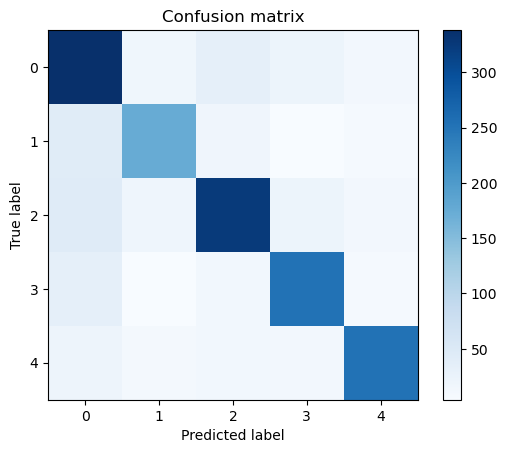

Accuracy:  0.7837521917007598
F1 score 'macro' 0.7843697203082047
ARI 0.5259


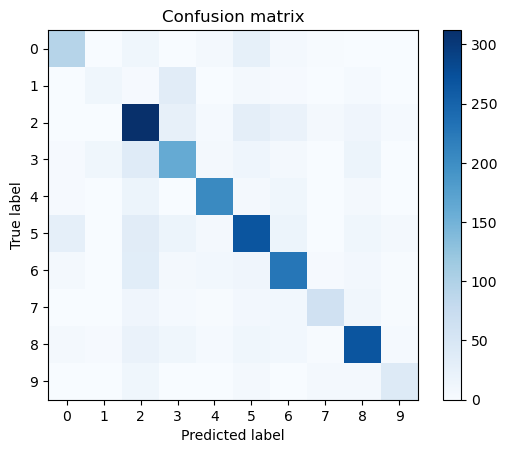

Accuracy:  0.7020913358941528
F1 score 'macro' 0.6536307687811923
ARI 0.4532


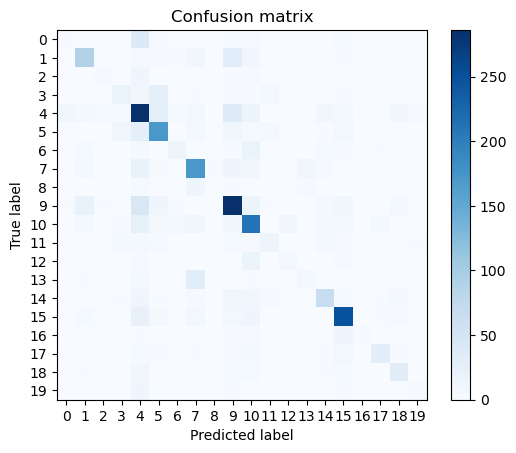

Accuracy:  0.6067907995618839
F1 score 'macro' 0.4208846210534622
ARI 0.3756


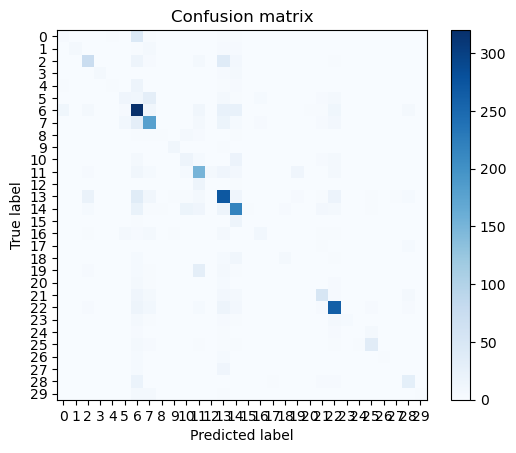

Accuracy:  0.5736806031528444
F1 score 'macro' 0.3347358603599953
ARI 0.3545


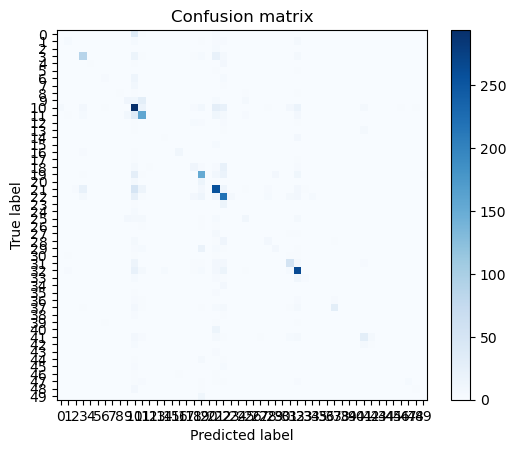

Accuracy:  0.5277957336780866
F1 score 'macro' 0.22469110541030438
ARI 0.3043


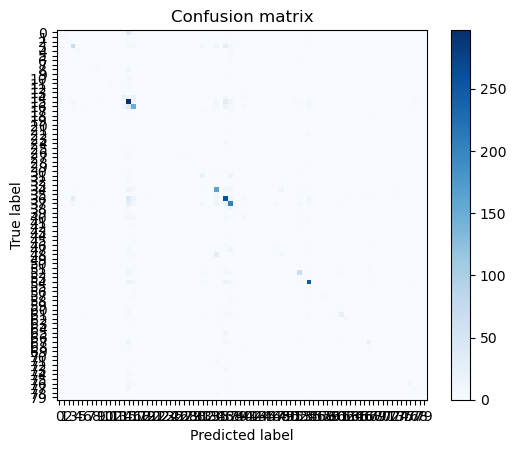

Accuracy:  0.5079563182527301
F1 score 'macro' 0.17154895178595117
ARI 0.2865


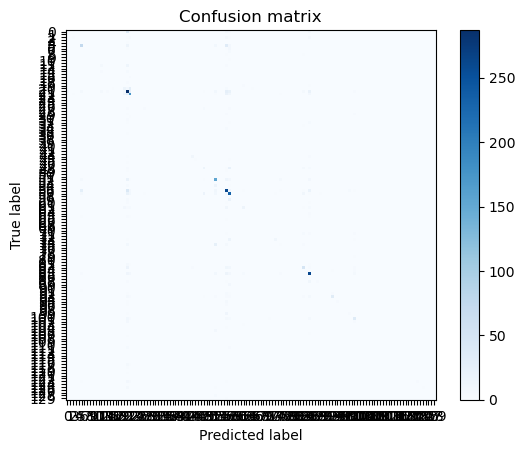

Accuracy:  0.5076173065204144
F1 score 'macro' 0.09777561015410349
ARI 0.2966


In [ ]:
# without PCA for 7 different groups of tags
for n_tag in [5,10,20,30,50,80,130]:
    dft = df.sample(10000)
    tags_to_keep = dft.Single_most_used_tag.value_counts()[:n_tag].index.to_list()

    X = dft.loc[df.Single_most_used_tag.isin(tags_to_keep)]
    y = LabelEncoder().fit_transform(X.Single_most_used_tag)

    X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33, random_state=125, stratify=y)

    X_train_ = X_train.no_stopword.apply(lambda x: " ".join(x))

    vectorizer = CountVectorizer(min_df=2).fit(X_train_)
    X_train_vec = vectorizer.transform(X_train_)
    X_test_vec = vectorizer.transform(X_test.no_stopword.apply(lambda x: " ".join(x)))

    scaler = StandardScaler()
    X_train_sc = scaler.fit_transform(X_train_vec.toarray())
    X_test_sc = scaler.transform(X_test_vec.toarray())

    time_0 = time.time()
    clf = LogisticRegression(multi_class='ovr').fit(X_train_vec.toarray(), y_train)
    fit_time = time.time()-time_0
    time_0 = time.time()
    y_pred = clf.predict(X_test_vec.toarray())
    predict_time=time.time()-time_0
    accuracy, jaccard, f1_macro, precision, recall, ari = plot_results(y_test, y_pred)
    Results.loc[len(Results)] = ["",
                                     accuracy, jaccard, f1_macro, precision, recall, ari, fit_time,predict_time]

fit time PCA -42.47901391983032


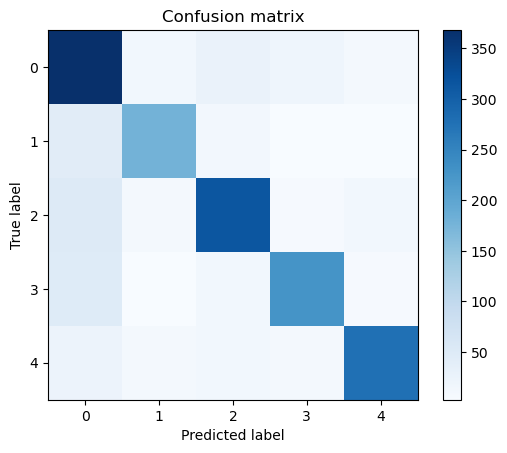

Accuracy:  0.7987126974839087
F1 score 'macro' 0.8014644131519992
ARI 0.5476
fit time PCA -113.82235217094421


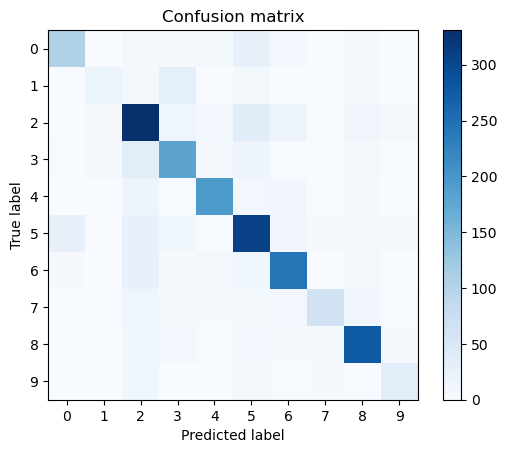

Accuracy:  0.7484035759897829
F1 score 'macro' 0.7011112862642851
ARI 0.5231
fit time PCA -131.71013617515564


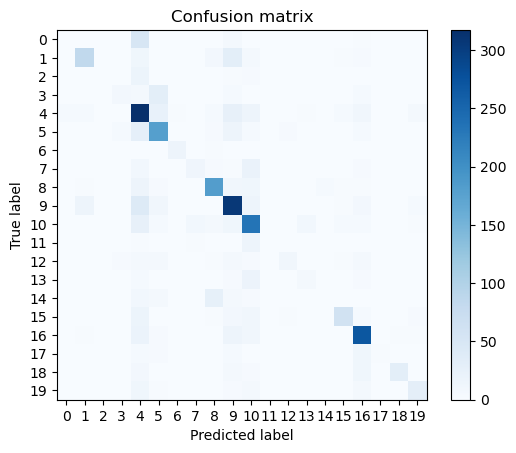

Accuracy:  0.6422794117647059
F1 score 'macro' 0.4359583895704679
ARI 0.4122
fit time PCA -146.08544087409973


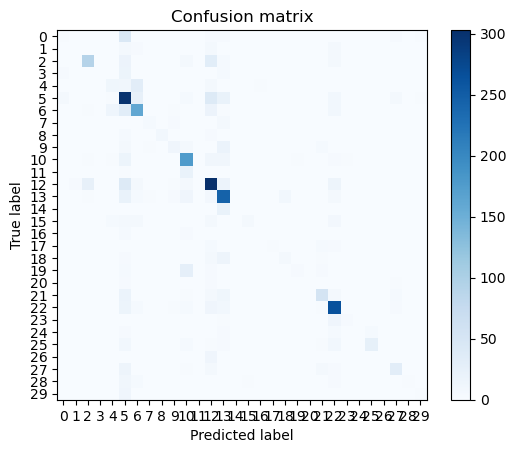

Accuracy:  0.5943983402489627
F1 score 'macro' 0.3202472594084081
ARI 0.3707
fit time PCA -159.39060473442078


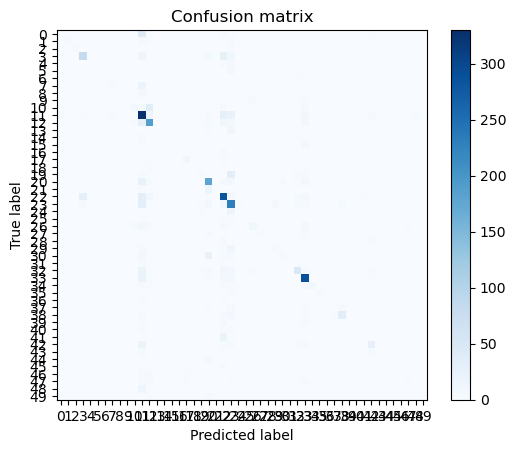

Accuracy:  0.5713825330325492
F1 score 'macro' 0.2290702109168494
ARI 0.3587
fit time PCA -161.74284958839417


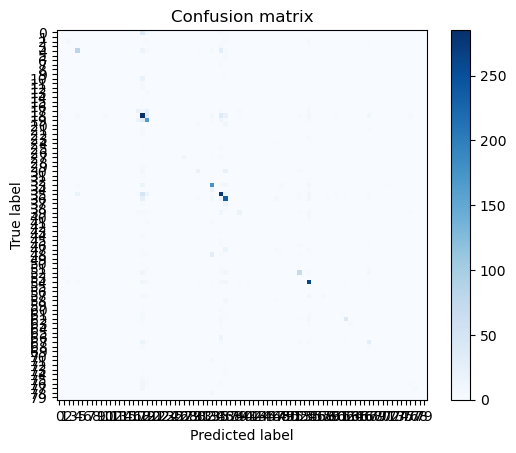

Accuracy:  0.535625
F1 score 'macro' 0.1313961888041682
ARI 0.3189
fit time PCA -171.8351092338562


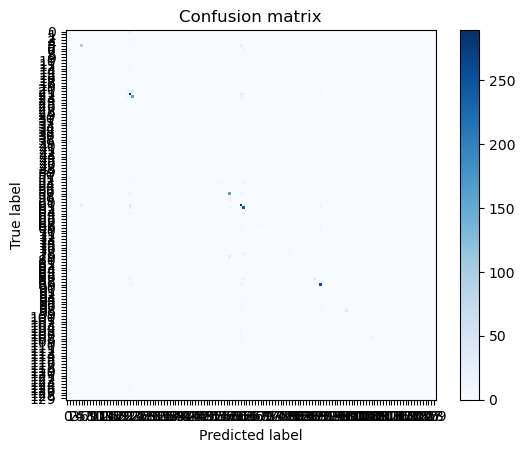

Accuracy:  0.515863331299573
F1 score 'macro' 0.0912379663101266
ARI 0.3029


In [ ]:
# with PCA for 7 different groups of tags
for n_tag in [5,10,20,30,50,80,130]:
    dft = df.sample(10000)
    tags_to_keep = dft.Single_most_used_tag.value_counts()[:n_tag].index.to_list()

    X = dft.loc[df.Single_most_used_tag.isin(tags_to_keep)]
    y = LabelEncoder().fit_transform(X.Single_most_used_tag)

    X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33, random_state=125, stratify=y)

    X_train_ = X_train.no_stopword.apply(lambda x: " ".join(x))

    vectorizer = CountVectorizer(min_df=2).fit(X_train_)
    X_train_vec = vectorizer.transform(X_train_)
    X_test_vec = vectorizer.transform(X_test.no_stopword.apply(lambda x: " ".join(x)))

    scaler = StandardScaler()
    X_train_sc = scaler.fit_transform(X_train_vec.toarray())
    X_test_sc = scaler.transform(X_test_vec.toarray())
    
    pca = PCA(n_components=3000)
    time_1=time.time()
    pca.fit(X_train_sc)
    print("fit time PCA", time_1-time.time())

    time_0 = time.time()
    clf = LogisticRegression(multi_class='ovr').fit(pca.transform(X_train_vec.toarray()), y_train)
    fit_time = time.time()-time_0
    time_0 = time.time()
    y_pred = clf.predict(pca.transform(X_test_vec.toarray()))
    predict_time=time.time()-time_0
    accuracy, jaccard, f1_macro, precision, recall, ari = plot_results(y_test, y_pred)
    Results.loc[len(Results)] = ["",
                                     accuracy, jaccard, f1_macro, precision, recall, ari, fit_time,predict_time]

In [ ]:
Results

,Model,Jaccard,Accuray,f1_score,Precision,Recall,ARI,fit_time,predict
0,,0.646768,0.783752,0.784370,0.791147,0.779938,0.525859,21.508394,0.217835
1,,0.500859,0.702091,0.653631,0.680838,0.638971,0.453221,55.882895,0.336706
2,,0.293170,0.606791,0.420885,0.495480,0.400360,0.375649,135.497894,0.399167
3,,0.227228,0.573681,0.334736,0.425351,0.309879,0.354499,231.856531,0.494196
4,,0.144372,0.527796,0.224691,0.412673,0.202635,0.304294,375.677554,1.071111
5,,0.110992,0.507956,0.171549,0.421546,0.150201,0.286485,547.479661,0.628934
6,,0.063788,0.507617,0.097776,0.582791,0.088238,0.296573,834.818197,0.771099
7,,0.670004,0.798713,0.801464,0.815893,0.792445,0.547582,7.109786,2.318667
8,,0.553131,0.748404,0.701111,0.742100,0.680325,0.523128,14.388509,3.438562
9,,0.318572,0.642279,0.435958,0.600900,0.415272,0.412152,23.535135,4.346399


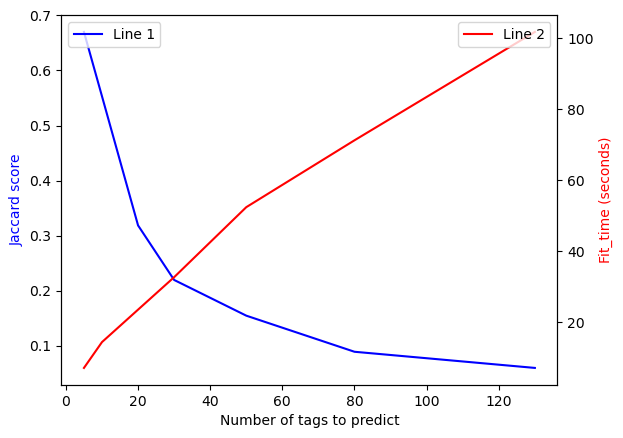

In [ ]:
x = [5,10,20,30,50,80,130]
y1 = Results.loc[7:,['Jaccard']]
y2 = Results.loc[7:,['fit_time']]

fig, ax1 = plt.subplots()

ax1.plot(x, y1, 'b-', label='Line 1')
ax1.set_xlabel('Number of tags to predict')
ax1.set_ylabel('Jaccard score', color='b')

ax2 = ax1.twinx()
ax2.plot(x, y2, 'r-', label='Line 2')
ax2.set_ylabel('Fit_time (seconds)', color='r')


ax1.legend(loc='upper left')
ax2.legend(loc='upper right')
plt.show()

/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


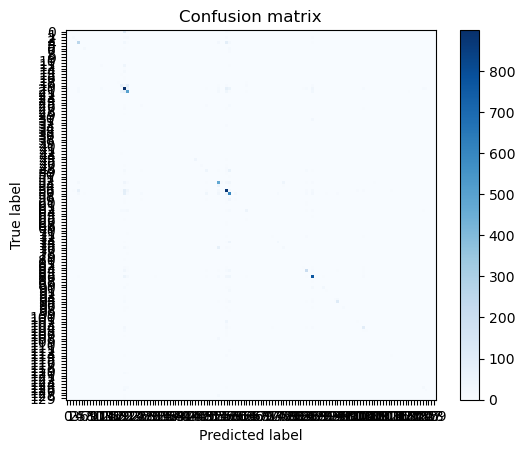

Accuracy:  0.5335368956743003
F1 score 'macro' 0.14216634962925503
ARI 0.337


In [ ]:
dft = df.sample(30000)
tags_to_keep = dft.Single_most_used_tag.value_counts()[:130].index.to_list()

X = dft.loc[df.Single_most_used_tag.isin(tags_to_keep)]
y = LabelEncoder().fit_transform(X.Single_most_used_tag)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33, random_state=125, stratify=y)


X_train_ = X_train.no_stopword.apply(lambda x: " ".join(x))

vectorizer = CountVectorizer(min_df=2).fit(X_train_)
X_train_vec = vectorizer.transform(X_train_)
X_test_vec = vectorizer.transform(X_test.no_stopword.apply(lambda x: " ".join(x)))



scaler = StandardScaler()
X_train_sc = scaler.fit_transform(X_train_vec.toarray())
X_test_sc = scaler.transform(X_test_vec.toarray())

time_0 = time.time()
clf = LogisticRegression(multi_class='ovr').fit(X_train_vec, y_train)
fit_time = time.time()-time_0
time_0 = time.time()
y_pred = clf.predict(X_test_vec)
predict_time=time.time()-time_0
accuracy, jaccard, f1_macro, precision, recall, ari = plot_results(y_test, y_pred)
Results.loc[len(Results)] = ["",
                                     accuracy, jaccard, f1_macro, precision, recall, ari, fit_time,predict_time]

In [ ]:
# test plot so see how much variance is explained

n_components = 3000
pca = PCA(n_components=n_components)
time_1=time.time()
pca.fit(X_train_sc)
print("fit time PCA", time_1-time.time())
pca.explained_variance_ratio_
scree = (pca.explained_variance_ratio_*100).round(2)

scree_cum = scree.cumsum()
x_list = range(1, n_components+1)

plt.bar(x_list, scree)
plt.plot(x_list, scree_cum,c="red",marker='o')
plt.xlabel("rang de l'axe d'inertie")
plt.ylabel("pourcentage d'inertie")
plt.title("Eboulis des valeurs propres")
plt.show(block=False)

In [ ]:
print(f"the vocabulary for the sampled df comprises {X_train_sc.shape[1]} words")
print("PCA allow to reduce this vocabularu to 1000 variables that can explain 100% of variations")


time_0 = time.time()
clf = LogisticRegression(multi_class='ovr').fit(pca.transform(X_train_vec.toarray()), y_train)
fit_time=time.time()-time_0
time_0 = time.time()
y_pred = clf.predict(pca.transform(X_test_vec.toarray()))
predict_time=time.time()-time_0

accuracy, jaccard, f1_macro, precision, recall, ari = plot_results(y_test, y_pred)
Results.loc[len(Results)] = ["",
                                     accuracy, jaccard, f1_macro, precision, recall, ari, fit_time,predict_time]

In [ ]:
Results

,Model,Jaccard,Accuray,f1_score,Precision,Recall,ARI,fit_time,predict
0,,0.646768,0.783752,0.784370,0.791147,0.779938,0.525859,21.508394,0.217835
1,,0.500859,0.702091,0.653631,0.680838,0.638971,0.453221,55.882895,0.336706
2,,0.293170,0.606791,0.420885,0.495480,0.400360,0.375649,135.497894,0.399167
3,,0.227228,0.573681,0.334736,0.425351,0.309879,0.354499,231.856531,0.494196
4,,0.144372,0.527796,0.224691,0.412673,0.202635,0.304294,375.677554,1.071111
5,,0.110992,0.507956,0.171549,0.421546,0.150201,0.286485,547.479661,0.628934
6,,0.063788,0.507617,0.097776,0.582791,0.088238,0.296573,834.818197,0.771099
7,,0.670004,0.798713,0.801464,0.815893,0.792445,0.547582,7.109786,2.318667
8,,0.553131,0.748404,0.701111,0.742100,0.680325,0.523128,14.388509,3.438562
9,,0.318572,0.642279,0.435958,0.600900,0.415272,0.412152,23.535135,4.346399


/opt/conda/lib/python3.10/site-packages/wordcloud/wordcloud.py:106: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  self.colormap = plt.cm.get_cmap(colormap)


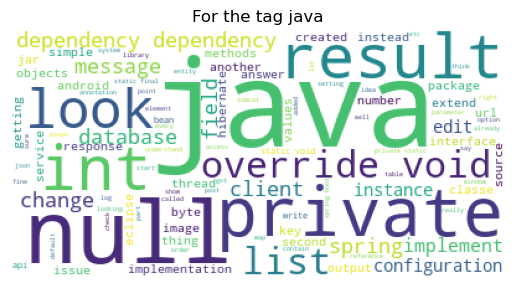

In [ ]:
corpus = make_corpus(df.loc[df.Single_most_used_tag == "java",'no_stopword'].apply(lambda x:" ".join(x)))
word_cloud = wordcloud.WordCloud(background_color='white',
                         stopwords=None,
                         max_words=100).generate(" ".join(corpus))
plt.title("For the tag java")
plt.imshow(word_cloud)
plt.axis("off")
plt.show()

# representation des 10 mots les plus communs du corpus dans un graphe 3D

In [ ]:
import gensim

w2v_model = gensim.models.Word2Vec(min_count= 2,
                                   window=3,
                                   vector_size=100,
                                   seed=42,
                                   workers=1)
sentences = df.no_stopword
w2v_model.build_vocab(sentences)
w2v_model.train(sentences, total_examples=w2v_model.corpus_count, epochs=20)
model_vectors = w2v_model.wv
w2v_words = model_vectors.index_to_key
print("Vocabulary size: %i" % len(w2v_words))
print("Word2Vec trained")



Vocabulary size: 154784
Word2Vec trained


In [ ]:
corpus_tag = [tag for tag in df.Tags_list for tag in tag]   # flattening list of list
tags_to_plot = [tag[0] for tag in Counter(corpus_tag).most_common(20)]
words_2_plot = set(tags_to_plot).intersection(set(w2v_words))
words_2_plot

{'android',
 'css',
 'html',
 'ios',
 'iphone',
 'java',
 'javascript',
 'jquery',
 'linux',
 'performance',
 'php',
 'python',
 'sql'}

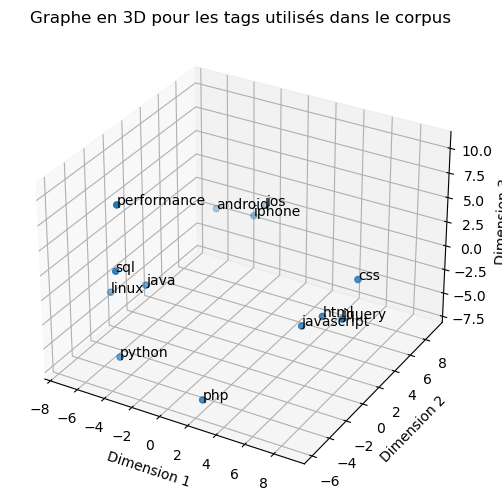

In [ ]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

word_vectors = [w2v_model.wv[word] for word in words_2_plot]

pca = PCA(n_components=3)
word_in_3d = pca.fit_transform(word_vectors)
x = word_in_3d[:, 0]
y = word_in_3d[:, 1]
z = word_in_3d[:, 2]


fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x, y, z)
for i, word in enumerate(words_2_plot):
    ax.text(x[i], y[i], z[i], word)

ax.set_xlabel('Dimension 1')
ax.set_ylabel('Dimension 2')
ax.set_zlabel('Dimension 3')
ax.set_title('Graphe en 3D pour les tags utilisés dans le corpus')
plt.show()

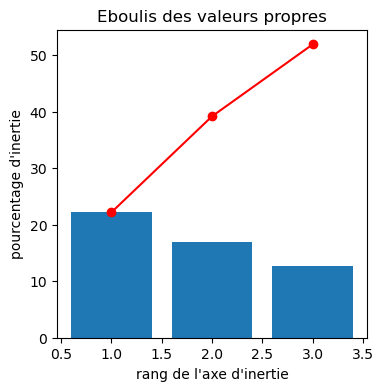

In [ ]:
scree = (pca.explained_variance_ratio_*100).round(2)

scree_cum = scree.cumsum()
x_list = range(1, 4)


fig = plt.figure(figsize=(4, 4))
plt.bar(x_list, scree)
plt.plot(x_list, scree_cum,c="red",marker='o')
plt.xlabel("rang de l'axe d'inertie")
plt.ylabel("pourcentage d'inertie")
plt.title("Eboulis des valeurs propres")
plt.show(block=False)